<a href="https://colab.research.google.com/github/girlwcode/2021DataYouthCampus/blob/master/Week3/13_Text_generation_with_an_RNN_(%EB%AC%B8%EC%A0%9C).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow 실습 : RNN을 이용한 텍스트 생성

- 학습 속도를 위해, GPU를 사용하기를 권장

In [1]:
import tensorflow as tf

import numpy as np
import os
import time
import matplotlib.pyplot as plt

# history를 그래프로 그리기 위해 사용
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

## Shakespeare's writing 데이터셋 

- 이 데이터셋은 Shakespeare의 writing을 모아놓은 데이터셋
- 본 실습에서는 해당 데이터셋을 이용하여, character level language model을 학습하고 이를 텍스트 생성에 활용하고자 함


### Download the Shakespeare dataset

In [2]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1122304/1115394 [==============================] - 0s 0us/step


### Read the data

먼저 다운로드한 파일을 살펴보면, 

In [3]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print ('Length of text: {} characters'.format(len(text)))

Length of text: 1115394 characters


In [4]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [5]:
# The unique characters in the file
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

65 unique characters


### Vectorize the text

- 각각의 character를 정수(integer)의 index로 표현하기 위해, 두개의 look-up table을 정의함
  - character => 숫자
  - 숫자 => character

In [6]:
# 고유 문자에서 인덱스로 매핑 생성
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

- 이제 각 character와 숫자를 encode, decode할 수 있는 look-up table이 준비되었음

In [7]:
char2idx

{'\n': 0,
 ' ': 1,
 '!': 2,
 '$': 3,
 '&': 4,
 "'": 5,
 ',': 6,
 '-': 7,
 '.': 8,
 '3': 9,
 ':': 10,
 ';': 11,
 '?': 12,
 'A': 13,
 'B': 14,
 'C': 15,
 'D': 16,
 'E': 17,
 'F': 18,
 'G': 19,
 'H': 20,
 'I': 21,
 'J': 22,
 'K': 23,
 'L': 24,
 'M': 25,
 'N': 26,
 'O': 27,
 'P': 28,
 'Q': 29,
 'R': 30,
 'S': 31,
 'T': 32,
 'U': 33,
 'V': 34,
 'W': 35,
 'X': 36,
 'Y': 37,
 'Z': 38,
 'a': 39,
 'b': 40,
 'c': 41,
 'd': 42,
 'e': 43,
 'f': 44,
 'g': 45,
 'h': 46,
 'i': 47,
 'j': 48,
 'k': 49,
 'l': 50,
 'm': 51,
 'n': 52,
 'o': 53,
 'p': 54,
 'q': 55,
 'r': 56,
 's': 57,
 't': 58,
 'u': 59,
 'v': 60,
 'w': 61,
 'x': 62,
 'y': 63,
 'z': 64}

In [8]:
# 텍스트에서 처음 13개의 문자가 숫자로 어떻게 매핑되었는지를 보여줍니다
print ('{} ---- 문자들이 다음의 정수로 매핑되었습니다 ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'First Citizen' ---- 문자들이 다음의 정수로 매핑되었습니다 ---- > [18 47 56 57 58  1 15 47 58 47 64 43 52]


### language model 학습을 위한 input과 target 만들기
- language model을 학습하기 위해서는 첫번째 부터 t번째 step의 input sequence를 알고 있을 때, t+1번째 step에는 어떤 token이 나오는지에 대한 정답이 필요
- 이를 위해, 먼저 전체 텍스트를 일정한 character 개수 간격으로 나누어서 input sequence를 구성
- 각 input sequence에서 target을 만드는 방법은 input sequence에서 오른쪽으로 한칸씩 이동시키는 것
  - ex) `Hello` => input : `Hell` , target : `ello`


In [9]:
# 단일 입력에 대해 원하는 문장의 최대 길이
seq_length = 100
examples_per_epoch = len(text)//seq_length

# 훈련 샘플/타깃 만들기
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(idx2char[i.numpy()])

print('텍스트 총 글자수 : ', len(text_as_int))

F
i
r
s
t
텍스트 총 글자수 :  1115394


In [10]:
# batch를 이용하여 앞에서부터 순서대로, 총 101개의 문자를 하나의 문장으로 만들어 줌
# drop_remainder : 마지막 배치는 101개보다 작은 수로 문장이 만들어지므로 제거함
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


- 각각의 101개의 글자로 이루어진 문장을 길이 100의 input sequence와 길이 100의 target sequence로 변환

In [11]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [12]:
# input과 target 예시
for input_example, target_example in  dataset.take(1):
  print ('입력 데이터: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('타깃 데이터: ', repr(''.join(idx2char[target_example.numpy()])))

입력 데이터:  'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
타깃 데이터:  'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


### 모델 학습을 위해, mini batch로 구성


- 이전에 사용한 batch는 문장으로 나누기 위해 사용한 것이므로, 실제 mini batch로 나누는 과정을 적용
- 실험 과정을 간단히 하기 위해, 학습 데이터셋과 validation 데이터셋으로만 분리

In [13]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

train_dataset = dataset.take(examples_per_epoch // 4 * 3)
valid_dataset = dataset.skip(examples_per_epoch // 4 * 3)

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
valid_dataset = valid_dataset.batch(BATCH_SIZE)

print(train_dataset)
print(len(list(train_dataset)))
print(len(list(valid_dataset)))

<BatchDataset shapes: ((None, 100), (None, 100)), types: (tf.int64, tf.int64)>
131
42


## RNN 모델을 이용한 텍스트 생성

### RNN 모델
- embedding layer, LSTM, Dense layer로 구성
  - input에 padding이 없으므로, masking하지 않음
  - 모든 time step에 대해, 다음 time step의 target을 맞추도록 학습하기 위해 return_sequence=True
  - 마지막 dense layer는 다음 time step의 글자가 무엇인지 맞추어야 하므로, vocab size에 대해 logit 값을 계산

In [14]:
# 문자로 된 어휘 사전의 크기
vocab_size = len(vocab)

# 임베딩 차원
embedding_dim = 128

# RNN 유닛(unit) 개수
rnn_units = 128

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    tf.keras.layers.GRU(rnn_units, return_sequences=True),
    tf.keras.layers.Dense(vocab_size)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         8320      
_________________________________________________________________
gru (GRU)                    (None, None, 128)         99072     
_________________________________________________________________
dense (Dense)                (None, None, 65)          8385      
Total params: 115,777
Trainable params: 115,777
Non-trainable params: 0
_________________________________________________________________


![모델을 통과하는 데이터의 사진](https://tensorflow.org/tutorials/text/images/text_generation_training.png)

### 학습하기 전 모델 사용

In [15]:
for input_example_batch, target_example_batch in train_dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (배치 크기, 시퀀스 길이, 어휘 사전 크기)")

(64, 100, 65) # (배치 크기, 시퀀스 길이, 어휘 사전 크기)


### 옵티마이저(optimizer), 손실 함수, 평가 metric 선택

In [16]:
# multi-label classification과 동일하므로, cross entropy loss 이용
# 마지막 dense layer에 sigmoid activation이 없으므로 from_logits=True
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

###모델 학습 
- 여기서는 model.fit을 이용하면서, 매번 epoch이 끝날때마다 체크포인트(모델의 파라마터)를 저장하는 방법을 다뤄보려고 함
  - tf.keras.callbacks.ModelCheckpoint

In [17]:
# 체크포인트가 저장될 디렉토리
checkpoint_dir = './training_checkpoints'

# 체크포인트 파일 이름
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# model.fit 메소드에 함께 이용할 callback 
# 'val_loss'를 monitor하면서, 가장 val_loss가 작을때만 모델을 저장함 (save_best_only=True)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix, 
    save_weights_only=True, 
    monitor='val_loss',
    save_best_only=True)

In [18]:
history = model.fit(train_dataset, epochs=20,
                    validation_data=valid_dataset,
                    callbacks=[checkpoint_callback])
                    

Epoch 1/20
131/131 [==============================] - 6s 22ms/step - loss: 3.0656 - accuracy: 0.2126 - val_loss: 2.5479 - val_accuracy: 0.2929
Epoch 2/20
131/131 [==============================] - 3s 20ms/step - loss: 2.3690 - accuracy: 0.3267 - val_loss: 2.2876 - val_accuracy: 0.3429
Epoch 3/20
131/131 [==============================] - 3s 19ms/step - loss: 2.1671 - accuracy: 0.3752 - val_loss: 2.1404 - val_accuracy: 0.3742
Epoch 4/20
131/131 [==============================] - 3s 20ms/step - loss: 2.0204 - accuracy: 0.4100 - val_loss: 2.0422 - val_accuracy: 0.3954
Epoch 5/20
131/131 [==============================] - 3s 19ms/step - loss: 1.9156 - accuracy: 0.4366 - val_loss: 1.9788 - val_accuracy: 0.4115
Epoch 6/20
131/131 [==============================] - 3s 19ms/step - loss: 1.8353 - accuracy: 0.4592 - val_loss: 1.9368 - val_accuracy: 0.4282
Epoch 7/20
131/131 [==============================] - 3s 19ms/step - loss: 1.7728 - accuracy: 0.4774 - val_loss: 1.9024 - val_accuracy: 0.4418

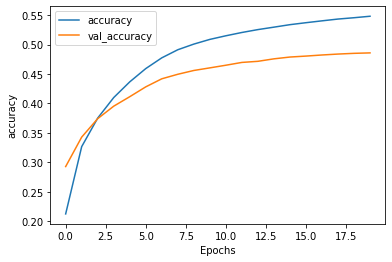

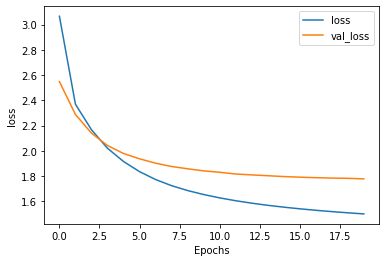

In [19]:
# 그래프 그리기
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### Best model 복원

- validation loss를 기준으로 best 모델만 저장했으므로, 마지막에 저장된 모델이 최종 Best 모델

In [20]:
print(tf.train.latest_checkpoint(checkpoint_dir))
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

./training_checkpoints/ckpt_20


### 학습된 모델 활용

학습된 모델을 이용하여 텍스트를 생성하려고 함

* 시작 문자열 선택과 순환 신경망 상태를 초기화하고 생성할 문자 수를 설정

* 시작 문자열과 순환 신경망 상태를 사용하여 다음 문자를 예측

* 다음, `tf.random.categorical`을 사용하여 output logit값을 바탕으로 랜덤 샘플링

* 이 예측된 문자를 모델의 다음 입력으로 활용

* 하나의 token을 계속 추가하는 방식으로 autoregressive 하게 샘플링하는 방법을 사용함

* 이를 통해, 길이가 긴 text를 생성하는 것도 가능함

![텍스트를 생성하기 위해 모델의 출력이 입력으로 피드백](https://tensorflow.org/tutorials/text/images/text_generation_sampling.png)

- 생성된 텍스트를 보면 모델이 언제 대문자로 나타나고, 절을 만들고 셰익스피어와 유사한 어휘를 가져오는지 알 수 있음
- 그러나 훈련 Epoch이 적은 관계로 논리적인 문장을 형성하는 것은 훈련되지 않음

In [21]:
def generate_text(model, start_string, temperature=1.0):
  # 평가 단계 (학습된 모델을 사용하여 텍스트 생성)

  # 생성할 문자의 수
  num_generate = 1000

  # 시작 문자열을 숫자로 변환(벡터화)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # 결과를 저장할 빈 문자열
  text_generated = []

  # 온도(temperature)가 낮으면 더 예측 가능한 텍스트가 됩니다.
  # 온도가 높으면 더 의외의 텍스트가 됩니다.
  # 최적의 세팅을 찾기 위한 실험

  # 여기에서 배치 크기 == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # 배치 차원 제거
      predictions = tf.squeeze(predictions, 0)

      # 범주형 분포를 사용하여 모델에서 리턴한 단어 샘플링 (logit 값에 따라 샘플링)
      predictions = predictions / temperature
      # sample된 token들 중 마지막 token만 선택
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # 예측된 단어를 다음 입력으로 모델에 전달
      # 이전 은닉 상태와 함께
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [22]:
print(generate_text(model, start_string="ROMEO: ", temperature=1.0))

ROMEO: Ifrst Ineforil M-ge mave d llgr, QUMe brs sat gishar:
Nut he weathalll in th CO!
HEN tho;
noaldine:
HO:
S at TII tovespon mecin h.
E conglve he celo seat tha les:
F t,
EXE we ispr WI f us whispbeandalue lve
S gam cus ED methon cknd.
Ifosice t't unopelar'Sthithed ce carillishisce op MEXE dledgrea uthelichilisth?
IARZF pe are afoueave cous cler y LA s wherdanofed ld t ld VE ghowire t in l.
AUK:
Th:
Tivinowacomis! t ces nese LIZAGH?
Tildae,
mat Rit histonerses, ll CUS;
s ILo.
Ther cerabe y!
LO:
Wheex rend Thon!
Yor cho und
wy tha?
FFI cungonondameanoousplo
OLAUSI wissthans! wame.
INIUNere!
Wes ha wis w iver'
RETheo mand ut, thade'tho gardis ts, d t n, binanitoret he stud omy turout thar, ho f tyord walenyoin:
Heto s,
Boran ithan y wh bl megread haithacouladin LI gr fon jup s cabar s ban RGHI sthe POXCh:
Sed canonalend windonote there s whanabef he t allithe a ano'louthanE af belles,
BUCinin fin gatwhin A
THAPindolde a.
F gan-brve abonera wish RI't weff:
TENeen:
ETAd she chourorsqus

- 결과를 개선하는 가장 쉬운 방법은 더 오래 훈련하는 것(ex: `EPOCHS = 30`).
- 이외에 시도해볼 수 있는 것들
  - 다른 시작 문자열
  - RNN 모델 네트워크 구조 수정
  - temperature 조정 
    - 값이 작으면, 예측된 logit 값이 큰 token이 주로 샘플링 
    - 값이 크면, 예측된 logit 값이 작은 token도 샘플링 될 확률이 높아짐

- 다음 문제 실습을 위해, 학습된 모델 삭제

In [23]:
del model

## RNN 실습
데이터셋은 그대로 이용하고 나머지 부분을 직접 구현해보기

### 문제 1: RNN 모델 만들기
- 조건: 딥러닝 모델의 각 layer는 1번부터 5번까지 순서대로 구성
1. embedding layer, input_dim: vocab size, output_dim: 256
2. LSTM layer, hidden units 512
3. layer normalization
4. dense layer, hidden node: 256, activation ReLU
5. dense layer, hidden node: vocab size
- 딥러닝 모델을 만드는 두가지 방식(tf.keras.Model, tf.keras.models.Sequential) 중 선택하여 만들기

In [28]:
# 여기에 문제 1에 대한 코드를 작성하면 됩니다.
# 문자로 된 어휘 사전의 크기
vocab_size = len(vocab)

# 임베딩 차원
embedding_dim = 256

# RNN 유닛(unit) 개수
rnn_units = 512

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    tf.keras.layers.LSTM(rnn_units, return_sequences=True),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(vocab_size)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 256)         16640     
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 512)         1574912   
_________________________________________________________________
layer_normalization_3 (Layer (None, None, 512)         1024      
_________________________________________________________________
dense_1 (Dense)              (None, None, 256)         131328    
_________________________________________________________________
dense_2 (Dense)              (None, None, 65)          16705     
Total params: 1,740,609
Trainable params: 1,740,609
Non-trainable params: 0
_________________________________________________________________


###옵티마이저(optimizer), 손실 함수, 평가 metric 선택
- 기존과 동일함

In [29]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

### 모델 학습 및 평가
- 체크포인트를 저장하는 checkpoint_dir 및 전체 epoch 수를 제외하고, 기존과 동일함

In [30]:
# 체크포인트가 저장될 디렉토리
checkpoint_dir = './checkpoints'

# 체크포인트 파일 이름
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# model.fit 메소드에 함께 이용할 callback 
# 'val_loss'를 monitor하면서, 가장 val_loss가 작을때만 모델을 저장함 (save_best_only=True)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix, 
    save_weights_only=True, 
    monitor='val_loss',
    save_best_only=True)

# 학습 시간을 위해 10 epoch만 학습
history = model.fit(train_dataset, epochs=10,
                    validation_data=valid_dataset,
                    callbacks=[checkpoint_callback])

Epoch 1/10
131/131 [==============================] - 9s 46ms/step - loss: 2.4095 - accuracy: 0.3337 - val_loss: 2.1280 - val_accuracy: 0.3799
Epoch 2/10
131/131 [==============================] - 6s 43ms/step - loss: 1.8954 - accuracy: 0.4448 - val_loss: 1.9736 - val_accuracy: 0.4270
Epoch 3/10
131/131 [==============================] - 6s 43ms/step - loss: 1.7166 - accuracy: 0.4898 - val_loss: 1.9072 - val_accuracy: 0.4490
Epoch 4/10
131/131 [==============================] - 6s 42ms/step - loss: 1.6108 - accuracy: 0.5175 - val_loss: 1.8624 - val_accuracy: 0.4675
Epoch 5/10
131/131 [==============================] - 6s 42ms/step - loss: 1.5384 - accuracy: 0.5354 - val_loss: 1.8263 - val_accuracy: 0.4812
Epoch 6/10
131/131 [==============================] - 6s 42ms/step - loss: 1.4799 - accuracy: 0.5506 - val_loss: 1.8017 - val_accuracy: 0.4896
Epoch 7/10
131/131 [==============================] - 6s 42ms/step - loss: 1.4331 - accuracy: 0.5626 - val_loss: 1.7787 - val_accuracy: 0.4960

### 문제 2: 학습된 모델 활용

위에서 정의된 `generate_text` 함수를 이용하여 텍스트를 생성해보기
- 조건1: 학습된 모델중에서 validation loss를 기준으로 best model 이용하기
- 조건2: "JULIET: "을 `start_string`으로 하고, `temperature`를 0.2, 1.0, 100.0으로 바꾸어 가면서 결과를 출력하고, 출력 결과를 비교하기
- 조건3: temperature는 1.0으로 고정하고, `start_string`을 자유롭게 1가지 넣어보기

In [35]:
# 여기에 문제 2에 대한 코드를 작성하면 됩니다.
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
temp = [.2,1.,100.0]
for t in temp : 
  print("temperature: ", t)
  print(generate_text(model, start_string="JULIET: ", temperature=t))
  print("------------------------------------------------------------")

print(generate_text(model, start_string="YELYN: ", temperature=1.0),end="\n")

temperature:  0.2
JULIET: I t t the t t t the t t t t t t the thint the t t t t the t t t t t the hat the t ther t the t t the the t t t t t t t t t the thine t t t t t t t thanthe t t thenthe t the t t t the the t the t t the t t the the t t the t this t the the the the t the t t the t me t t t t thist he t t the t t t the t me t t t t t at t t the t the t the t t t the the t t t t t t the t t whe t t the t t thint t allll the t t t t t the t t t t t t t t t wint t t t t t t t the t t t t the the the the t the t the the the the t t the the t t t t the t t t t t t t t t mat t t that t t t the the t t t the t t t t the the the t t the t the t t t t t t t the the t t t the t t t t t the t the t t t t the t t the the t t t at the t the t t the t that t t t the t the t t t the t t at t at the t t t t t t t t the the t t the t t t t t t t t the t t t t t the t thint t t t t t t t s the t the t t t t t t the t s t t s the the t the t t t t t t t t the t t t me t thenour t t t t t t t the t t